In [5]:
pip install -q tf-nightly

SyntaxError: invalid syntax (<ipython-input-5-fd90133f3ed4>, line 1)

In [6]:
pip install tensorflow-datasets

  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21500 sha256=40e38c00790612b0b3db955fc348911ed8b24b1de716347335b75ff99daad8d5
  Stored in directory: c:\users\ik533\appdata\local\pip\cache\wheels\54\aa\01\724885182f93150035a2a91bce34a12877e8067a97baaf5dc8
Successfully built promise
Note: you may need to restart the kernel to use updated packages.


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

데이터 세트 다운

In [8]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dataset tf_flowers downloaded and prepared to C:\Users\ik533\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


꽃 데이터 세트 5개 클래스 확인

In [9]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


데이터세트 이미지 검색 , 사용 , 데이터 증강 수행 

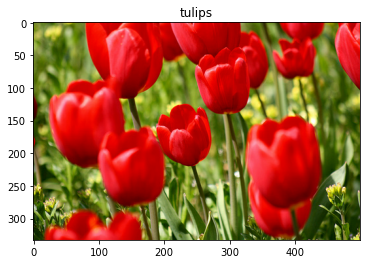

In [20]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

크기 및 배율 조정 

In [21]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

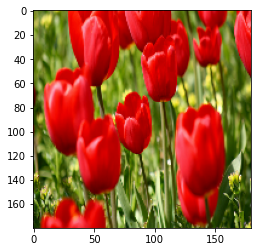

In [22]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [23]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


데이터 증강 

In [24]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [25]:
# Add the image to a batch
image = tf.expand_dims(image, 0)

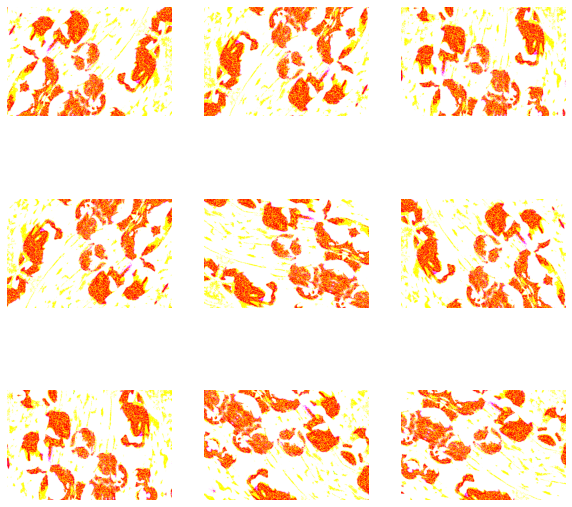

In [26]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

전처리 레이어를 사용하는 두가지 옵션 
1. 전처리 레이어를 모델의 일부로 만들기 

In [27]:
model = tf.keras.Sequential([
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model
])

2. 데이터세트에 전처리 레이어 적용ㅎ하기

In [28]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

데이터세트에 전처리 레이어 적용하기 

In [29]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [30]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

모델 훈련 

In [31]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 41s 426ms/step - loss: 1.3490 - accuracy: 0.4091 - val_loss: 1.2199 - val_accuracy: 0.5177
Epoch 2/5
92/92 [==============================] - 40s 429ms/step - loss: 1.1371 - accuracy: 0.5426 - val_loss: 1.0555 - val_accuracy: 0.6185
Epoch 3/5
92/92 [==============================] - 39s 422ms/step - loss: 1.0187 - accuracy: 0.6046 - val_loss: 1.0262 - val_accuracy: 0.5967
Epoch 4/5
92/92 [==============================] - 41s 435ms/step - loss: 0.9623 - accuracy: 0.6236 - val_loss: 0.9326 - val_accuracy: 0.6485
Epoch 5/5
92/92 [==============================] - 41s 435ms/step - loss: 0.9241 - accuracy: 0.6233 - val_loss: 0.9758 - val_accuracy: 0.6158


In [34]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

12/12 [==============================] - 1s 102ms/step - loss: 0.9288 - accuracy: 0.6185
Accuracy 0.6185286045074463


사용자 정의 데이터 증강 

In [35]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [36]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

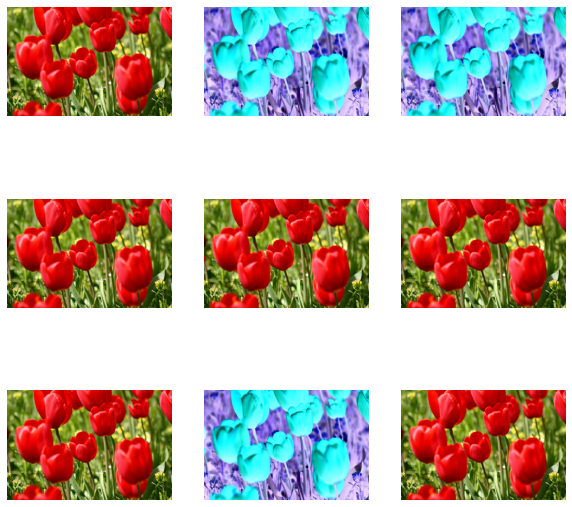

In [37]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

서브클래스 생성 구현 

In [38]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

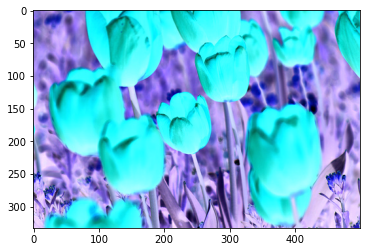

In [39]:
_ = plt.imshow(RandomInvert()(image)[0])

tf.image 사용 

In [40]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

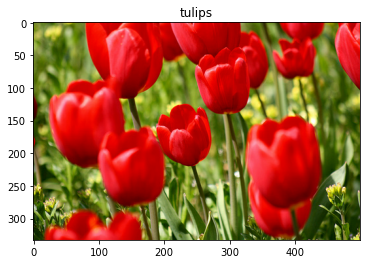

In [41]:
#작업할 이지미 검색
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [42]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

데이터 증강 이미지 뒤집기 

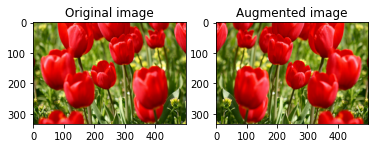

In [43]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

이미지 회색조로 만들기 

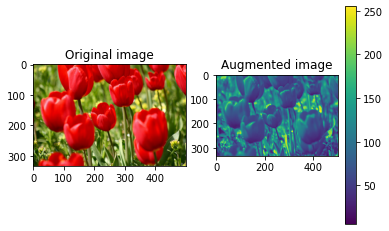

In [44]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

이미지 포화시키기 

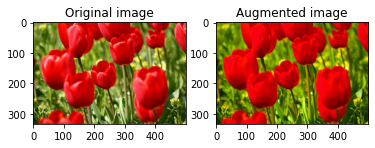

In [45]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

이미지 밝기 변경 

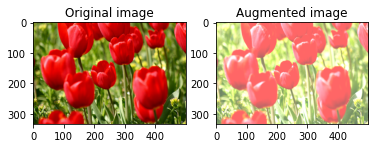

In [46]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

이미지 중앙 자르기 

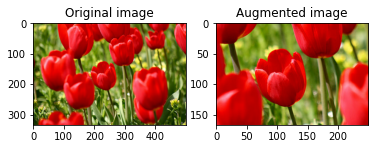

In [47]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

이미지 회전 90도

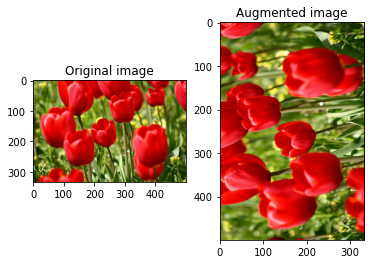

In [48]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

데이터세트에 증강 적용하기 

In [49]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

In [50]:
def augment(image,label):
  image, label = resize_and_rescale(image, label)
  # Add 6 pixels of padding
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6) 
   # Random crop back to the original size
  image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  image = tf.clip_by_value(image, 0, 1)
  return image, label

데이터 세트 구성 

In [51]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [52]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [53]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)